In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from __future__ import division

In [3]:
train_path = 'train.csv'
test_path = 'test.csv'

#### rename the id and target variabel

In [13]:
train = pd.read_csv(train_path)
train.rename(columns ={'TARGET':'target', 'ID':'id'}, inplace = True)
test = pd.read_csv(test_path)
test.rename(columns ={'TARGET':'target', 'ID':'id'}, inplace = True)

In [5]:
train.head()

,id,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,target
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


#### generate a new feature which count the number of zeroes in each sample the data is very sparse

In [14]:
zeros = (train == 0).sum(axis = 1)
train['zeros'] = zeros
zeros = (test == 0).sum(axis = 1)
test['zeros'] = zeros

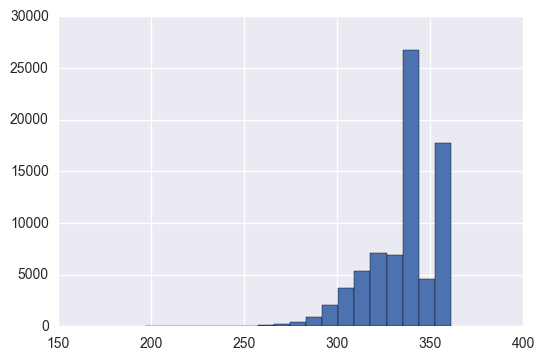

In [15]:
plt.hist(zeros, bins = 20)
plt.show()
# we need to create an variable to record the number of zeros

#### perform feature selection based on variables

#### var3 could be nationality, and most of them belongs to category 2

In [9]:
print train[train.var3 == 2].target.value_counts(normalize = True)
unhappy_by_nation = train.groupby('var3').target.sum()
customer_by_nation = train.groupby('var3').target.apply(len)
rate_by_nation = unhappy_by_nation / customer_by_nation
print rate_by_nation.sort_values(ascending = False).head()
print customer_by_nation[customer_by_nation.sort_values(ascending = False) > 10].head()
# we see most nations has no more than 5 persons

0    0.96021
1    0.03979
Name: target, dtype: float64
var3
111    0.500000
116    0.500000
114    0.200000
142    0.166667
1      0.104762
Name: target, dtype: float64
var3
-999999      116
 0            75
 1           105
 2         74165
 3           108
Name: target, dtype: int64


In [18]:
# group the countries which has no more than 10 customer records into a category
major_nation = train.groupby('var3').apply(len) > 10
major_nation = major_nation[major_nation].index
print major_nation # the nations with more than 10 people
unhappy = rate_by_nation[rate_by_nation != 0].index
print unhappy # countries that has unhappy customers
#### so from -999999 to 15, there are enough people (>10) and unhappy customers, we treat them 
#### separately, we use one_hot encoding to treat them and the rest

Int64Index([-999999, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', name=u'var3')
Int64Index([-999999,       0,       1,       2,       3,       4,       5,
                  6,       7,       8,       9,      10,      11,      12,
                 13,      14,      15,     111,     114,     116,     142],
           dtype='int64', name=u'var3')


In [17]:
common_nation = set(test.var3.unique()).intersection((train.var3.unique()))
print len(common_nation) # so there are unseen countries in test3

176


#### save the test and train id customers

In [19]:
test_id = test.id
train_id = train.id
print set(test_id).intersection(set(train_id)) # there is no overlap in id
print all(test.columns == train.columns) # they have the same features

In [40]:
df = pd.concat([train.iloc[:-1], test], axis = 0) 
# perform feature engineering on both training, testing
df.shape

(151837, 372)

#### group the countries with more than 10 person into a group, called 16, and replace 999999 by -1

In [23]:
nations = df.var3.unique().tolist()
minor_nation = [nation for nation in nations if nation not in major_nation]
print minor_nation

[229, 178, 110, 177, 137, 17, 148, 122, 22, 58, 121, 127, 33, 125, 209, 72, 31, 51, 16, 107, 174, 141, 191, 104, 129, 18, 49, 73, 94, 131, 219, 187, 114, 28, 89, 115, 53, 126, 47, 84, 235, 161, 197, 23, 30, 146, 158, 138, 26, 120, 66, 216, 215, 90, 20, 21, 103, 192, 142, 29, 163, 223, 95, 98, 38, 156, 97, 105, 150, 183, 184, 52, 54, 220, 25, 225, 86, 124, 27, 162, 19, 195, 218, 24, 60, 108, 82, 36, 102, 175, 144, 169, 64, 201, 79, 91, 159, 135, 45, 61, 189, 118, 168, 78, 188, 69, 48, 145, 154, 32, 99, 198, 186, 185, 208, 143, 164, 100, 231, 149, 200, 190, 116, 42, 165, 85, 96, 111, 74, 133, 167, 153, 217, 172, 205, 228, 134, 193, 211, 147, 43, 117, 46, 132, 106, 35, 81, 170, 166, 88, 173, 119, 152, 176, 68, 56, 128, 130, 151, 41, 171, 204, 50, 44, 196, 199, 34, 76, 93, 182, 55, 157, 112, 71, 207, 62, 210, 65, 181, 139, 136, 59, 213, 77, 101, 238, 63, 194, 40, 57, 87, 179, 75, 206, 222, 140, 113, 230, 67, 202, 180, 227, 92, 233, 39, 160, 123, 155, 37, 226, 212, 83, 109, 214]


In [42]:
df.var3.replace(minor_nation, 16, inplace = True) # replace even unseen countries by class 16
df.var3.replace(-999999, -1, inplace = True) # replace -999999 by -1 (probabily not necessary)

In [43]:
countries = pd.get_dummies(df.var3)
countries.columns = ['country' + str(d) for d in range(18)] # rename countries
df = pd.concat([df, countries], axis = 1)
df.drop('var3', axis = 1, inplace = True)

In [28]:
# perform log transform on var38 so it is log-normal, inparticular, we should separate
# 117310.979016
central = 117310.979016 # this is close to the mean of the rest of the data, it's 
                        # likely imputed by mean
non_central = df[(df.var38 > 117311) | (df.var38 < 117310.9)].index
log_var38 = np.log(df.var38)
log_var38 = (log_var38 - np.log(central)) / np.std(log_var38)
na_var38 = pd.get_dummies((central - 0.1 < df.var38) & (df.var38 < central + 0.1))
na_var38.columns= columns=['non_central', 'central']
df['log_var38'] = log_var38
df['non_central'] = na_var38.non_central
df.drop(['var38'], axis = 1, inplace = True) 
# use non-central and log-transformed var38 to replace var38
df.shape

In [34]:
df.columns[-1:-5:-1]

Index([u'log_var38', 16, 15, 14], dtype='object')

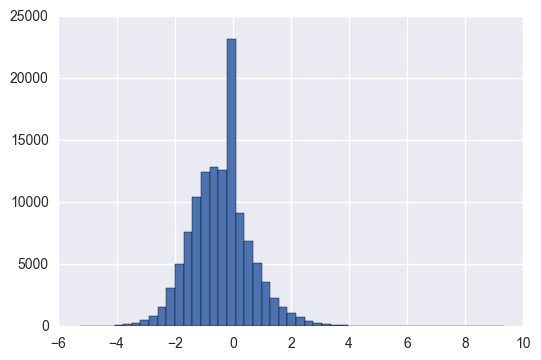

In [29]:
plt.hist(log_var38.iloc[non_central], bins = 50)
plt.show()

#### var15 is very important according to xgboost

In [ ]:
train.groupby('var15').target.value_counts().sort_values(ascending = False).head()

#### a case study of asset_40

In [ ]:
asset_40 = []
for name in train.columns:
    if 'var40' in name:
        asset_40.append(name)
print asset_40
compare = df[['num_var40', 'num_var40_0']]
train.target.value_counts(normalize=True)
compare[(compare.num_var40 != 0) & (compare.num_var40_0 !=0)].head()
# num_var40 and num_var40_0 are such that
# (0, 0) for 99% of customers
# (0, 3) for 0.7% of customers
# (3, 3) for 0.3% of customers
compare = train[['ind_var40', 'ind_var40_0', 'num_var40', 'num_var40_0', 'saldo_var40']]
compare.groupby('ind_var40').num_var40.value_counts()
compare.groupby('ind_var40').saldo_var40.value_counts().head()
# saldo_var remains zero when ind_var is zero, otherwise it can be many values
all(train.num_var40 == 3 * train.ind_var40)
# correlated data
train[train.num_var40_0 == 6]
# a single outlier is unsatisfied, so we can safely make it categorical and drop it
compare.groupby('ind_var40_0').num_var40_0.value_counts()
# so we can also drop num_var40_0
df.ind_var41.unique()
# ind_var41 is everywhere zero
train.groupby('ind_var41').target.value_counts(normalize = True)

#### find the constant columns

In [49]:
const_col = []
for name in df.columns:
    if len(df[name].unique()) == 1:
        const_col.append(name)

In [50]:
df.drop(const_col, axis = 1, inplace = True) # drop these

### to be done: find colinearity

In [ ]:
# chi2, pearson correlation, muli-linearity...

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
select = SelectKBest(f_classif, k = 20)

### to be done: generate new features

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, t_sne

#### find variables with less than 5 values

In [52]:
category_col = []
for name in df.columns:
    if 3 <= len(df[name].unique()) <= 10:
        category_col.append(name)
#### for num_op, these are 0, 3, 6, 9, for other variables, only 4 customers will have nonzero
#### value

### to be done: manually denoise these features
### try to learn, if such feature engineering should be performed, oversimplified?

In [ ]:
comments = [] # analyze the features and manually engineer these features in appropriate way
for name in category_col:
    print df.groupby(name).target.value_counts()
    #comment = raw_input('Comments:?')
    #comments.append([name, comment])

#### leaky in the comments means some values give either deterministic zero or one value
#### there are variables with strangely large value, then we categorize them with categorical
#### variables, more suitable for linear models

In [53]:
def checkPair(n):
    """
    put in the asset_number
    """ 
    print train.groupby(['num_var%d'%n, 'ind_var%d_0'%n]).target.value_counts()

In [ ]:
# even though var29, var29_0 are nonzero for only 8 samples, the above analysis shows we can't
# drop them to a single indicator variable

In [54]:
checkPair(33)

num_var33  ind_var33_0  target
0          0            0         72955
                        1          3008
           1            0             9
3          1            0            43
6          1            0             5
Name: target, dtype: int64


In [57]:
duplicates = []
for i in range(1, 50):
    try:
        checkPair(i)
        print '\n'
    except:
        continue

num_var1  ind_var1_0  target
0         0           0         72178
                      1          2971
          1           0           568
                      1            17
3         1           0           265
                      1            20
6         1           0             1
Name: target, dtype: int64




In [ ]:
'ind_var13_corto',
'ind_var13_corto_0',
'ind_var13_largo',
'ind_var13_largo_0',
'ind_var13_medio',
'ind_var13_medio_0',

In [ ]:
train.num_var4.value_counts()

In [ ]:
for name in train.columns:
    if 'num' in name and 'op' not in name and 'delta' not in name:
        print name

In [ ]:
train.groupby(['ind_var13_medio', 'ind_var13_medio_0']).target.value_counts()

In [ ]:
train.groupby(['ind_var25', 'ind_var25_0']).ind_var25_cte.value_counts()
# ind_var25, ind_var25_0 are identical

In [ ]:
for name in assets:

In [ ]:
train.groupby('ind_var2').ind_var2_0.value_counts()

In [ ]:
# var18 and var18_0 are the same

In [ ]:
train.shape

In [ ]:
duplicates = ['ind_var18', 'ind_var25', 'ind_var26', 'ind_var32', 'ind_var34', 'ind_var37']

In [ ]:
train.drop(duplicates, axis = 1, inplace = True)

In [ ]:
train.shape

### implement XGB model

In [58]:
import xgboost as xgb

In [59]:
from sklearn.model_selection import train_test_split

In [62]:
train = df.iloc[range(len(train)),:] # engineered training set
train.shape

(76020, 356)

In [122]:
#train.drop('id', axis = 1, inplace = True)
train_index, test_index = train_test_split(range(train.shape[0]))
Y = train.target.values
X = train.drop('target', axis = 1)

In [105]:
X_train = X.iloc[train_index]
X_validation = X.iloc[test_index]

X_train = X_train.as_matrix()
X_validation = X_validation.as_matrix()

In [123]:
type(X_train), type(Y)

(numpy.ndarray, numpy.ndarray)

In [134]:
Y_train = Y[train_index]
Y_validation = Y[test_index]

### for the engineered data

In [71]:
params ={
    'max_depth' : 6,
    'learning_rate' : 0.03,
    'n_estimators' : 150,
    'silent' : False,
    'objective' : 'binary:logistic',
    'reg_alpha' : 2.5,
    'eta' : 0.03,
    'subsample' : 0.8,
    'colsample_bytree' : 0.7,
    'min_child_weight' : 1,
    'eval_metric' : 'auc'
}
num_rounds = 10

In [138]:
gbm = xgb.XGBClassifier(
    max_depth = 6,
    learning_rate = 0.03,
    n_estimators = 150,
    silent = False,
    objective = 'binary:logistic',
    reg_alpha = 2.5
)

In [139]:
gbm.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.03, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='binary:logistic', reg_alpha=2.5, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

In [77]:
from sklearn.metrics import roc_auc_score

In [140]:
thresholds = [0.5, 0.9, 0.95, 0.96, 0.97, 0.975, 0.980]
for threshold in thresholds:
    Y_pred_proba = gbm.predict_proba(X_validation)[:,0] # prob of predicting a zero
    Y_pred = np.array([0]*len(X_validation))
    for i in xrange(len(X_validation)):
        if Y_pred_proba[i] <= threshold:
            Y_pred[i] = 1
    score = roc_auc_score(Y_validation, Y_pred)
    print 'For threshold {:.3f}, the area under roc-curve is : {:.3f}'.format(threshold, score)

For threshold 0.500, the area under roc-curve is : 0.500
For threshold 0.900, the area under roc-curve is : 0.500
For threshold 0.950, the area under roc-curve is : 0.499
For threshold 0.960, the area under roc-curve is : 0.507
For threshold 0.970, the area under roc-curve is : 0.500
For threshold 0.975, the area under roc-curve is : 0.499
For threshold 0.980, the area under roc-curve is : 0.500
